# 訓練の可視化

## 準備

In [1]:
import os
import torch
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

from unet import UNet
from pspnet import PSPNet
from util import DiceCrossEntropyLoss


# VOC2012で用いるラベル
CLASSES = ['backgrounds','aeroplane','bicycle','bird','boat','bottle',
            'bus','car' ,'cat','chair','cow', 
            'diningtable','dog','horse','motorbike','person', 
            'potted plant', 'sheep', 'sofa', 'train', 'monitor','unlabeld'
            ]

# カラーパレットの作成
COLOR_PALETTE = np.array(Image.open("./VOCdevkit/VOC2012_sample/SegmentationClass/2007_000170.png").getpalette()).reshape(-1,3)
COLOR_PALETTE = COLOR_PALETTE.tolist()[:len(CLASSES)]

# データディレクトリ
img_dir = 'VOCdevkit/VOC2012_sample/JPEGImages'
gt_dir = 'VOCdevkit/VOC2012_sample/SegmentationClass'

## UNetの場合

In [ ]:
# 推論結果の可視化
def visualize(model, img_id, img_dir, gt_dir, device='cpu'):
    img_path = os.path.join(img_dir, img_id) + ".jpg"
    gt_path = os.path.join(gt_dir, img_id) + ".png"
    
    model.to(device)
    model.eval()
    criterion =  DiceCrossEntropyLoss(weight=None, dice_weight=0.5) # 損失関数
    
    with torch.no_grad():
        # 入力画像の前処理 (PIL画像 -> Tensor)
        inp_tensor = transforms.functional.to_tensor(Image.open(img_path))
        inp_resized = transforms.Resize(size=(256, 256), interpolation=transforms.InterpolationMode.NEAREST)(inp_tensor)
        inp_normalized = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(inp_resized)
        inp = inp_normalized.unsqueeze(0)

        # 正解画像の前処理 (PIL画像 -> NumPy -> Tensor)
        gt_np = np.asarray(Image.open(gt_path))
        gt_np = np.where(gt_np == 255, 0, gt_np)  # 範囲外の255を0に置換（または別のインデックスに）

        gt_tensor = torch.tensor(gt_np, dtype=torch.long)
        gt_tensor = gt_tensor.unsqueeze(0)
        gt_resized = transforms.Resize(size=(256, 256), interpolation=transforms.InterpolationMode.NEAREST)(gt_tensor)

        # 予測
        pred = model(inp)
        loss = criterion(pred, gt_resized) # loss計算
        print(f'Loss: {loss.item()}')

        inp_np = (inp_resized.numpy().transpose(1, 2, 0) * 255).astype(np.uint8)  # 表示用スケール
        pred_np = torch.argmax(pred, dim=1).cpu().detach().numpy()[0]
        pred_np = np.clip(pred_np, 0, len(COLOR_PALETTE) - 1).astype(np.int32)
        gt_resized = gt_resized.squeeze(0).detach().numpy().astype(np.int32)

        # カラーパレットの適用
        img_gt = np.array([[COLOR_PALETTE[gt_resized[i, j]] for j in range(256)] for i in range(256)], dtype=np.uint8)
        img_pred = np.array([[COLOR_PALETTE[pred_np[i, j]] for j in range(256)] for i in range(256)], dtype=np.uint8)

    # プロット
    fig = plt.figure(figsize=(16, 10))
    for i, im in enumerate([inp_np, img_gt, img_pred]):
        ax = fig.add_subplot(1, 3, i+1)
        ax.imshow(im)
        ax.set_title(["Input", "Ground Truth", "Prediction"][i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

model = UNet()

## PSPNetの場合

In [2]:
# 推論結果の可視化
def visualize(model, img_id, img_dir, gt_dir, device='cpu'):
    img_path = os.path.join(img_dir, img_id) + ".jpg"
    gt_path = os.path.join(gt_dir, img_id) + ".png"
    
    model.to(device)
    model.eval()
    criterion =  DiceCrossEntropyLoss(weight=None, dice_weight=0.5) # 損失関数

    with torch.no_grad():
        # 入力画像の前処理 (PIL画像 -> Tensor)
        inp_tensor = transforms.functional.to_tensor(Image.open(img_path))
        inp_resized = transforms.Resize(size=(256, 256), interpolation=transforms.InterpolationMode.NEAREST)(inp_tensor)
        inp_normalized = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(inp_resized)
        inp = inp_normalized.unsqueeze(0)

        # 正解画像の前処理 (PIL画像 -> NumPy -> Tensor)
        gt_np = np.asarray(Image.open(gt_path))
        gt_np = np.where(gt_np == 255, 0, gt_np)  # 範囲外の255を0に置換（または別のインデックスに）

        gt_tensor = torch.tensor(gt_np, dtype=torch.long)
        gt_tensor = gt_tensor.unsqueeze(0)
        gt_resized = transforms.Resize(size=(256, 256), interpolation=transforms.InterpolationMode.NEAREST)(gt_tensor)

        # 予測
        pred, _ = model(inp)
        loss = criterion(pred, gt_resized) # loss計算
        print(f'Loss: {loss.item()}')

        inp_np = (inp_resized.numpy().transpose(1, 2, 0) * 255).astype(np.uint8)  # 表示用スケール
        pred_np = torch.argmax(pred, dim=1).cpu().detach().numpy()[0]
        pred_np = np.clip(pred_np, 0, len(COLOR_PALETTE) - 1).astype(np.int32)
        gt_resized = gt_resized.squeeze(0).detach().numpy().astype(np.int32)

        # カラーパレットの適用
        img_gt = np.array([[COLOR_PALETTE[gt_resized[i, j]] for j in range(256)] for i in range(256)], dtype=np.uint8)
        img_pred = np.array([[COLOR_PALETTE[pred_np[i, j]] for j in range(256)] for i in range(256)], dtype=np.uint8)

    # プロット
    fig = plt.figure(figsize=(16, 10))
    for i, im in enumerate([inp_np, img_gt, img_pred]):
        ax = fig.add_subplot(1, 3, i+1)
        ax.imshow(im)
        ax.set_title(["Input", "Ground Truth", "Prediction"][i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

model = PSPNet(n_classes=22)

## 重み・ファイルパスの入力

In [ ]:
chkp_path = 'Path/to/chkp_path.pth'
checkpoint = torch.load(chkp_path, map_location='cpu', weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'], strict=False)

# 保存先
save_dir = './save_dir' # 訓練ログ保存ディレクトリ
save_name_prefix = 'save_name' # 訓練ログ保存名
csv_path = os.path.join(save_dir, f'{save_name_prefix}.csv')

## 推論結果

### 損失のプロット

(0.0, 2.0)

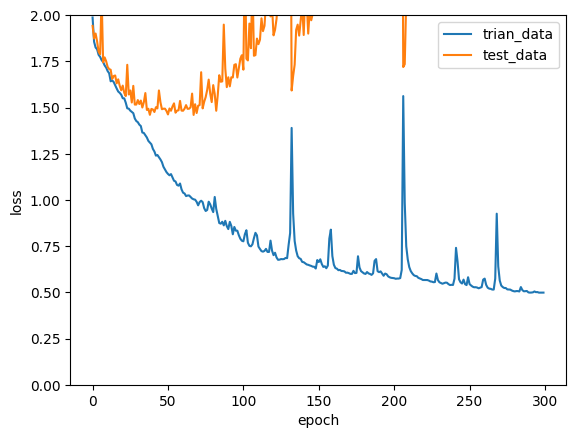

In [10]:
log_df = pd.read_csv(csv_path)
plt.plot(log_df['epoch'], log_df['train_loss'], label='trian_data')
plt.plot(log_df['epoch'], log_df['val_loss'], label='test_data')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim(0, 2)

     epoch  train_loss  val_loss
104    104    1.327536  1.355099


Text(0, 0.5, 'loss')

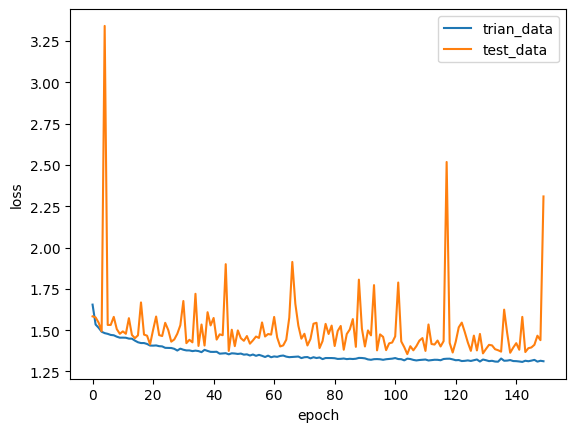

In [20]:
log_df = pd.read_csv(csv_path)
print(log_df[log_df['val_loss'] == log_df['val_loss'].min()])
plt.plot(log_df['epoch'], log_df['train_loss'], label='trian_data')
plt.plot(log_df['epoch'], log_df['val_loss'], label='test_data')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')

    epoch  train_loss  val_loss
44     44    1.174785  1.249073


Text(0, 0.5, 'loss')

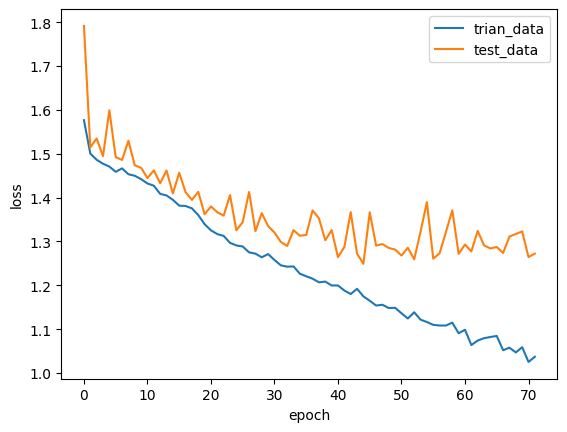

In [49]:
log_df = pd.read_csv(csv_path)
print(log_df[log_df['val_loss'] == log_df['val_loss'].min()])
plt.plot(log_df['epoch'], log_df['train_loss'], label='trian_data')
plt.plot(log_df['epoch'], log_df['val_loss'], label='test_data')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')

     epoch  train_loss  val_loss
120    120    1.160369  1.296497


Text(0, 0.5, 'loss')

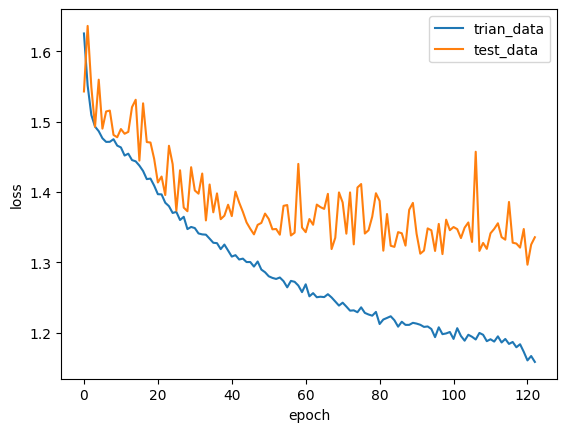

In [70]:
log_df = pd.read_csv(csv_path)
print(log_df[log_df['val_loss'] == log_df['val_loss'].min()])
plt.plot(log_df['epoch'], log_df['train_loss'], label='trian_data')
plt.plot(log_df['epoch'], log_df['val_loss'], label='test_data')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')

### 推論結果

<b>train data</b>

Loss: 0.5971869230270386


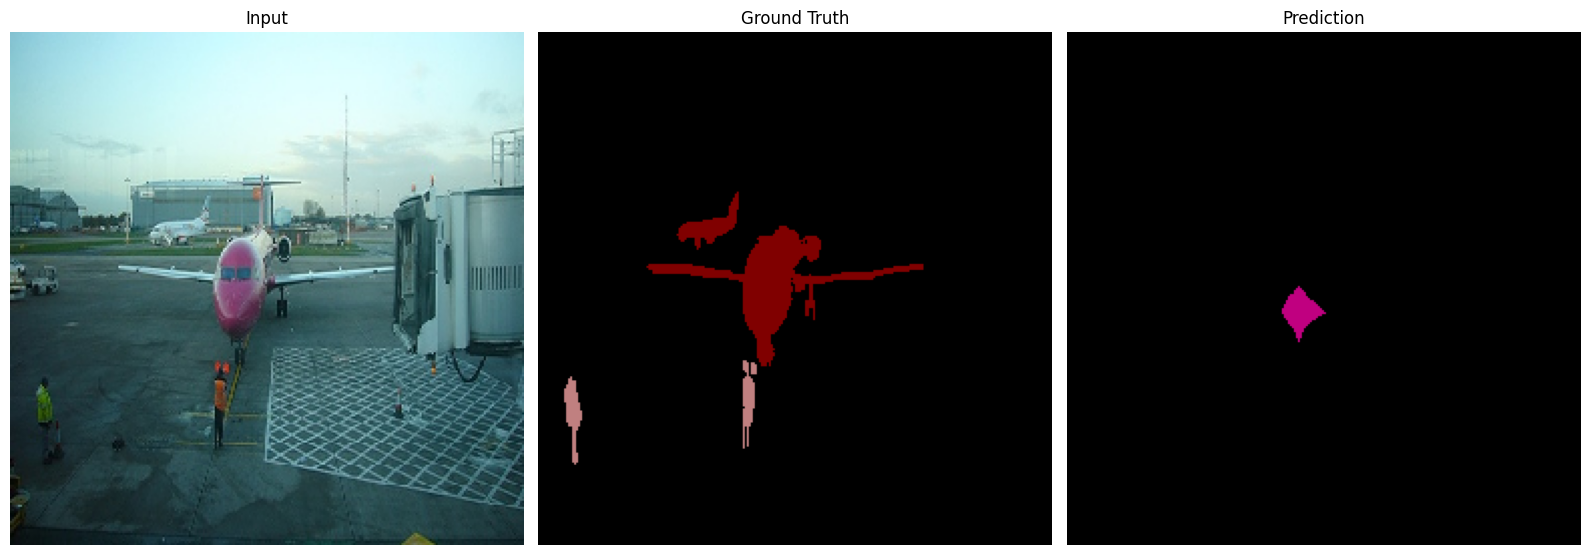

Loss: 1.040352463722229


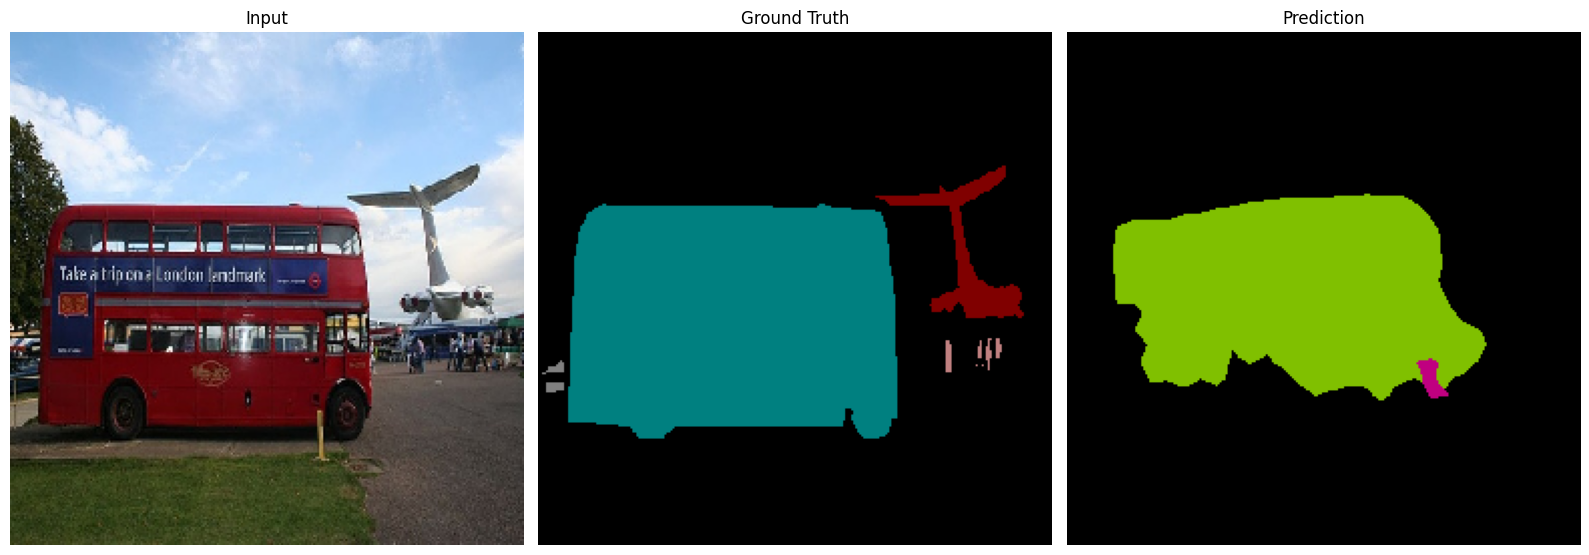

Loss: 1.244505763053894


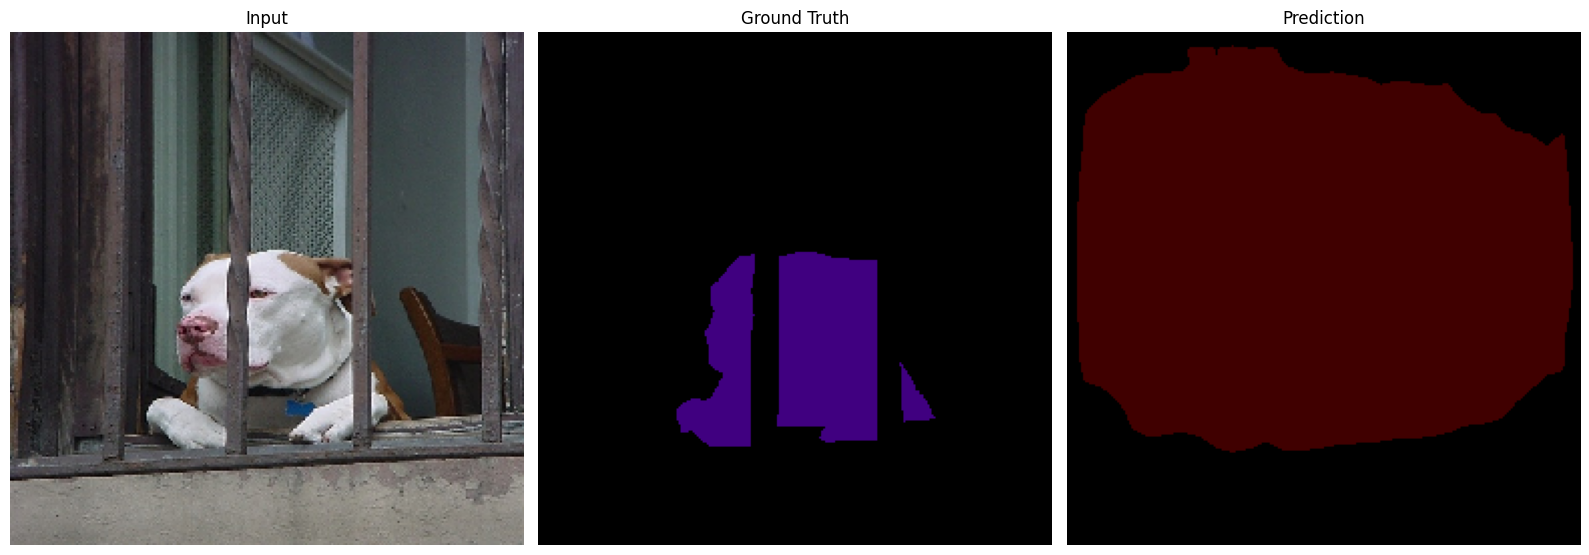

Loss: 1.5149418115615845


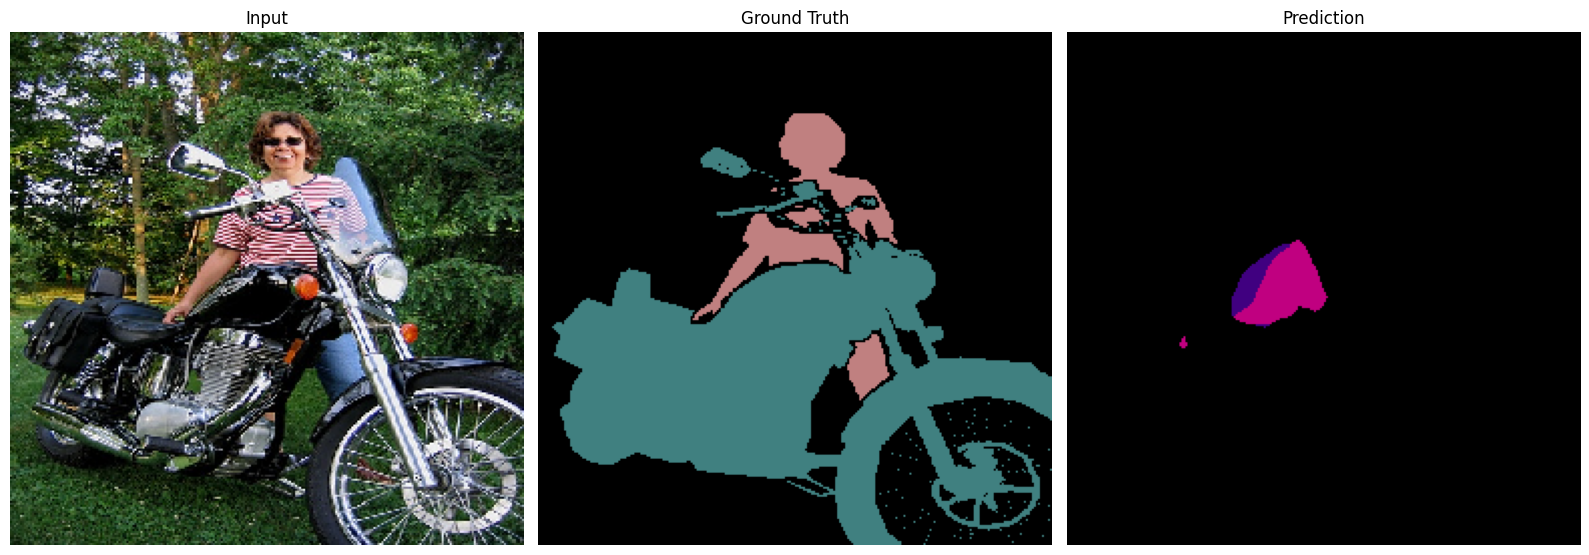

In [37]:
for id in ['2007_000032', '2007_000648', '2007_001225', '2007_002488']:
    visualize(model, id, img_dir, gt_dir)

<b>test data</b>

Loss: 1.2232964038848877


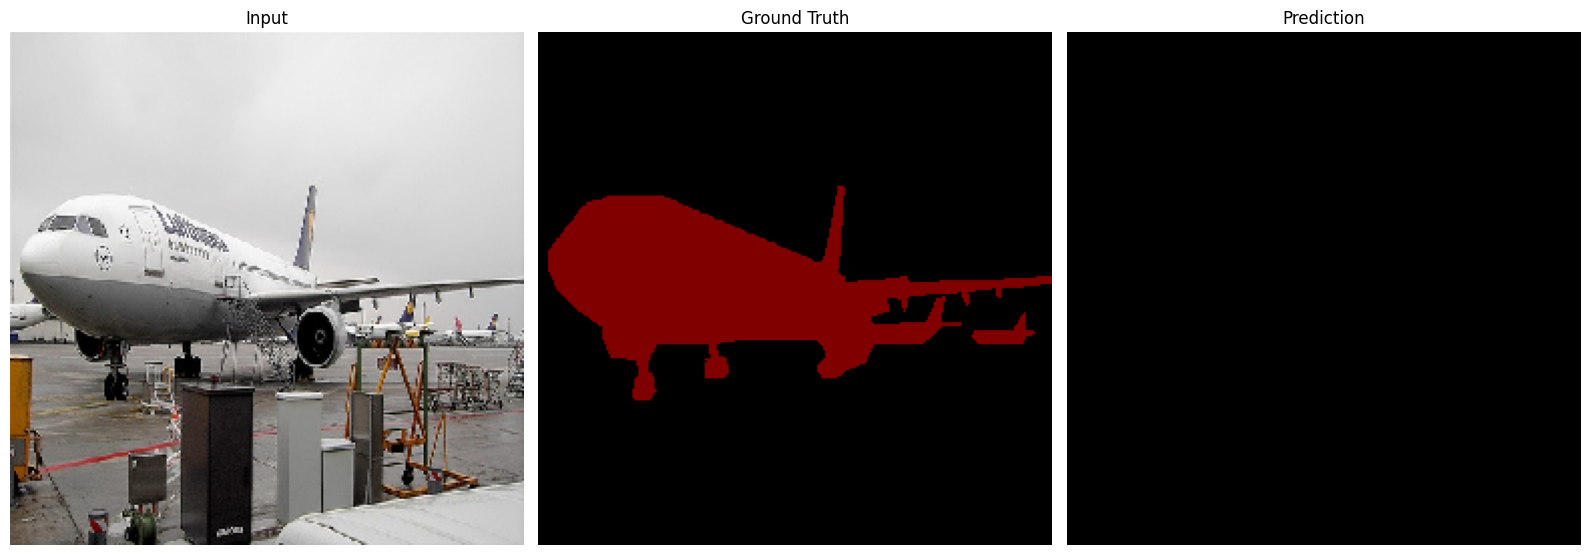

Loss: 1.6578950881958008


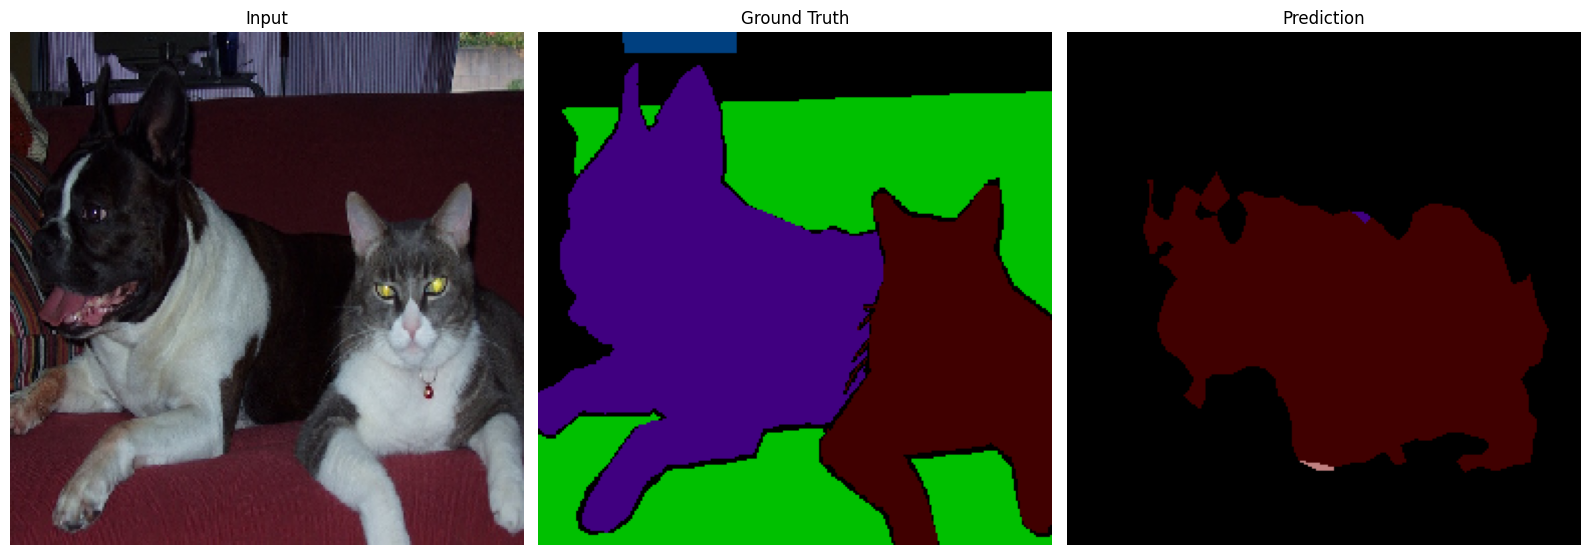

Loss: 0.6989548802375793


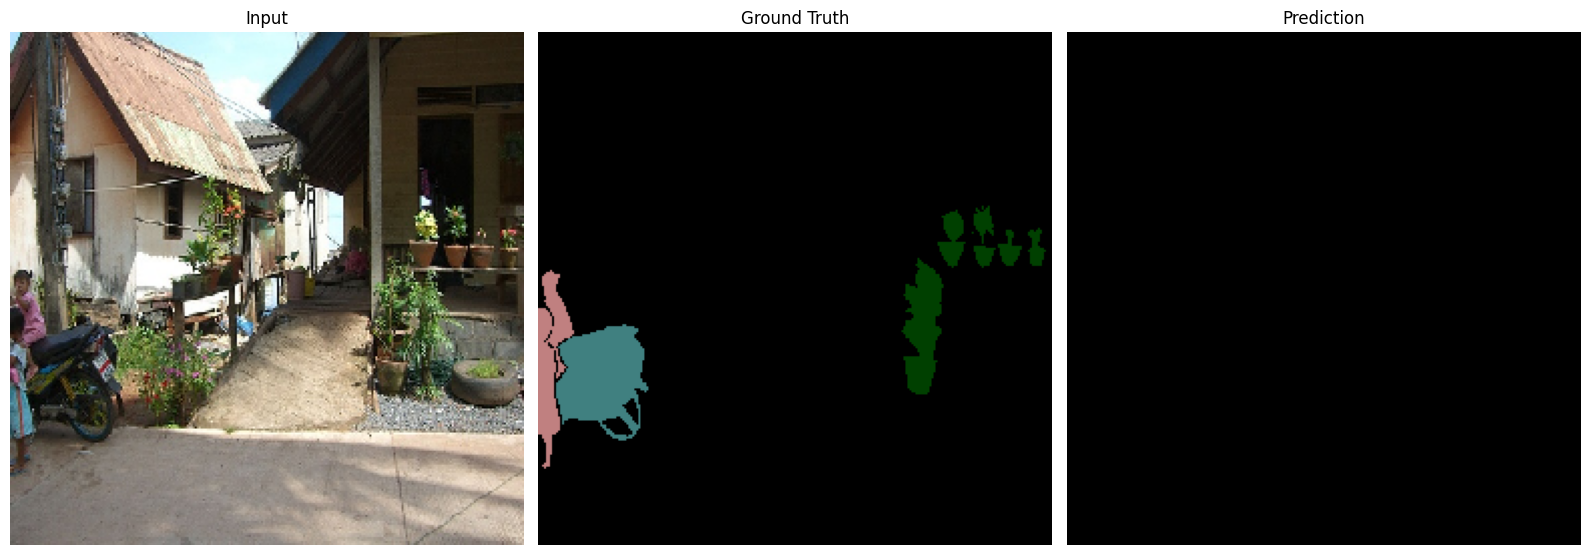

In [18]:
for id in ['2007_000033', '2007_001763', '2007_003367']:
    visualize(model, id, img_dir, gt_dir)